# Price prediction using LSTM for next 30 days - Banknifty

In [1]:
!pip install yfinance

In [2]:
# LinearRegression is a machine learning library for linear regression
from sklearn.linear_model import LinearRegression

# pandas and numpy are used for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn are used for plotting graphs
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# yahoo finance is used to fetch data
import yfinance as yf

In [3]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = '^NSEBANK'

In [4]:
# Read data
Df = yf.download('^NSEBANK', '2008-01-01', '2022-01-31', auto_adjust=True)
Df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2022-01-21,37522.351562,37741.000000,37224.250000,37574.300781,157800
2022-01-24,37601.949219,37694.699219,36375.351562,36947.550781,231000
2022-01-25,36598.050781,37788.800781,36415.601562,37706.750000,267500
2022-01-27,37058.199219,38147.648438,37012.250000,37982.101562,346300
2022-01-28,38246.601562,38421.699219,37581.500000,37689.398438,294300


In [5]:
# Only keep close columns
opn = Df[['Open']]
opn.tail()

,Open
Date,
2022-01-21,37522.351562
2022-01-24,37601.949219
2022-01-25,36598.050781
2022-01-27,37058.199219
2022-01-28,38246.601562


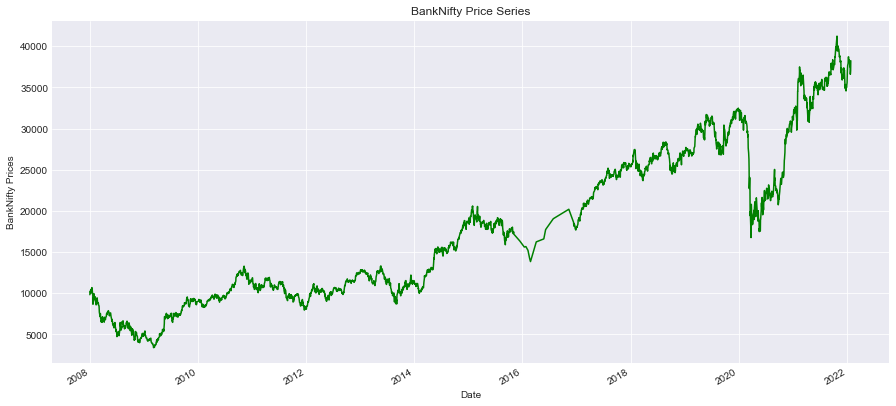

In [6]:
# Drop rows with missing values
opn = opn.dropna()

# Plot the closing price of NMDC
Df.Open.plot(figsize=(15, 7),color='g')
plt.ylabel("BankNifty Prices")
plt.title("BankNifty Price Series")
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
normalizer=MinMaxScaler(feature_range=(0,1))
opn_scaled=normalizer.fit_transform(np.array(opn).reshape(-1,1))

In [9]:
len(opn_scaled),len(opn)

(3176, 3176)

In [10]:
train_size=int(len(opn_scaled)*0.7)
test_size=len(opn_scaled)-train_size

In [11]:
train_size,test_size

(2223, 953)

In [12]:
opn_train,opn_test=opn_scaled[0:train_size,:],opn_scaled[train_size:len(opn_scaled),:1]

In [13]:
len(opn_train),len(opn_test)

(2223, 953)

In [14]:
def create_opn(dataset,step):
    xtrain,ytrain=[],[]
    for i in range(len(dataset)-step-1):
        a=dataset[i:(i+step),0]
        xtrain.append(a)
        ytrain.append(dataset[i+step,0])
    return np.array(xtrain),np.array(ytrain)

In [15]:
time_stamp=100
x_train,y_train=create_opn(opn_train,time_stamp)
x_test,y_test=create_opn(opn_test,time_stamp)

In [16]:
x_train.shape,y_train.shape

((2122, 100), (2122,))

In [17]:
x_test.shape,y_test.shape

((852, 100), (852,))

In [18]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [20]:
model=Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
34/34 [==============================] - 9s 144ms/step - loss: 0.0140 - val_loss: 0.0024
Epoch 2/100
34/34 [==============================] - 4s 106ms/step - loss: 4.4969e-04 - val_loss: 0.0022
Epoch 3/100
34/34 [==============================] - 4s 112ms/step - loss: 3.0027e-04 - val_loss: 0.0023
Epoch 4/100
34/34 [==============================] - 4s 110ms/step - loss: 2.8571e-04 - val_loss: 0.0024
Epoch 5/100
34/34 [==============================] - 4s 107ms/step - loss: 2.8783e-04 - val_loss: 0.0026
Epoch 6/100
34/34 [==============================] - 4s 108ms/step - loss: 2.8322e-04 - val_loss: 0.0021
Epoch 7/100
34/34 [==============================] - 4s 110ms/step - loss: 2.8298e-04 - val_loss: 0.0021
Epoch 8/100
34/34 [==============================] - 4s 111ms/step - loss: 2.6798e-04 - val_loss: 0.0025
Epoch 9/100
34/34 [==============================] - 4s 110ms/step - loss: 2.7434e-04 - val_loss: 0.0020
Epoch 10/100
34/34 [==============================] - 4s 10

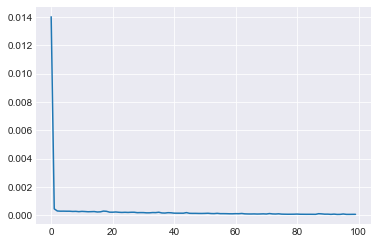

In [22]:
loss=model.history.history['loss']
plt.plot(loss)

In [23]:
#Predicitng on train and test data
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [24]:
train_predict=normalizer.inverse_transform(train_predict)
test_predict=normalizer.inverse_transform(test_predict)

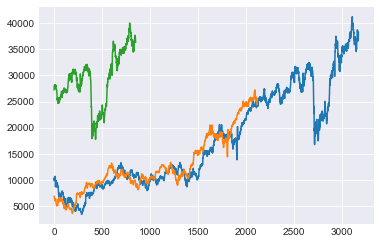

In [25]:
plt.plot(normalizer.inverse_transform(opn_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [26]:
type(train_predict)

numpy.ndarray

In [27]:
test=np.vstack((train_predict,test_predict))

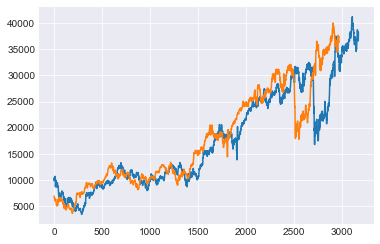

In [28]:
plt.plot(normalizer.inverse_transform(opn_scaled))
plt.plot(test)

In [29]:
len(opn_test)

953

In [36]:
#Getting the last 100 days records
fut_inp = opn_test[853:]

In [37]:
fut_inp = fut_inp.reshape(1,-1)

In [38]:
tmp_inp = list(fut_inp)

In [39]:
fut_inp.shape

(1, 100)

In [40]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [41]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.901825487613678], [0.8967477679252625], [0.8830699920654297], [0.868378221988678], [0.8551844954490662], [0.8449664115905762], [0.8380601406097412], [0.8338643312454224], [0.8312831521034241], [0.8291575908660889], [0.8265819549560547], [0.823067307472229], [0.8185526728630066], [0.8133022785186768], [0.8077463507652283], [0.8023198843002319], [0.7973454594612122], [0.7929770350456238], [0.7892052531242371], [0.7859004735946655], [0.7828778624534607], [0.7799554467201233], [0.7769978046417236], [0.7739362120628357], [0.7707667350769043], [0.7675326466560364], [0.7643004655838013], [0.7611356377601624], [0.7580859661102295], [0.7551737427711487]]


In [42]:
len(opn_scaled)

3176

In [43]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

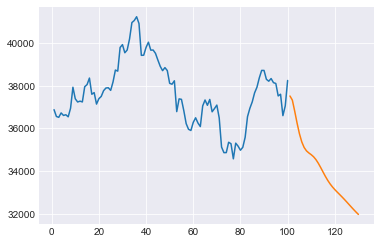

In [44]:
plt.plot(plot_new, normalizer.inverse_transform(opn_scaled[3076:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [45]:
opn_new=opn_scaled.tolist()

In [46]:
len(opn_new)

3176

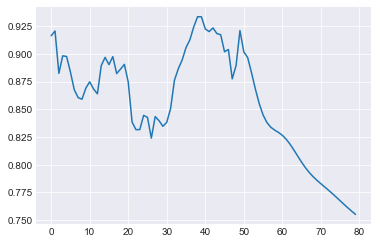

In [47]:
#Entends helps us to fill the missing value with approx value
opn_new.extend(lst_output)
plt.plot(opn_new[3126:])

In [48]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(opn_new).tolist()

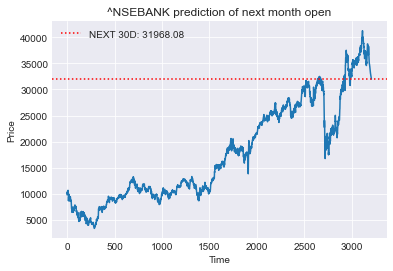

In [49]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()